# Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.
    
    THIS IS MEANT FOR EDUCATIONAL PURPOSES.  The condensed version is in strategy.ipynb

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
#symbol = 'SPY'
#symbol = '^DJI'
#symbol = 'DJA'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

Include dividends? (If yes, set to True)

In [4]:
use_adj = True

Fetch symbol data from internet; use cache if available.

In [5]:
ts = pf.fetch_timeseries(symbol)
ts.head()

dir_name data


,open,high,low,close,adj_close,volume
date,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,17.66,0
1928-01-03,17.76,17.76,17.76,17.76,17.76,0
1928-01-04,17.72,17.72,17.72,17.72,17.72,0
1928-01-05,17.55,17.55,17.55,17.55,17.55,0
1928-01-06,17.66,17.66,17.66,17.66,17.66,0


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [6]:
ts = pf.select_tradeperiod(ts, start, end, use_adj)
ts.head()

,open,high,low,close,adj_close,volume
date,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,17.66,0
1928-01-03,17.76,17.76,17.76,17.76,17.76,0
1928-01-04,17.72,17.72,17.72,17.72,17.72,0
1928-01-05,17.55,17.55,17.55,17.55,17.55,0
1928-01-06,17.66,17.66,17.66,17.66,17.66,0


Add technical indicator: 50 day ma and 200 day ma

In [7]:
sma50 = pf.SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = pf.SMA(ts, timeperiod=200)
ts['sma200'] = sma200

ts.head()

,open,high,low,close,adj_close,volume,sma50,sma200
date,,,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,17.66,0,NaN,NaN
1928-01-03,17.76,17.76,17.76,17.76,17.76,0,NaN,NaN
1928-01-04,17.72,17.72,17.72,17.72,17.72,0,NaN,NaN
1928-01-05,17.55,17.55,17.55,17.55,17.55,0,NaN,NaN
1928-01-06,17.66,17.66,17.66,17.66,17.66,0,NaN,NaN


Finalize the time series before implementing trading strategy

In [8]:
ts, start = pf.finalize_timeseries(ts, start, dropna=True, drop_columns=['open', 'high', 'low'])
ts.head()

,close,adj_close,volume,sma50,sma200
date,,,,,
1928-10-16,21.72,21.72,0,20.69,19.18
1928-10-17,21.79,21.79,0,20.73,19.20
1928-10-18,21.84,21.84,0,20.78,19.22
1928-10-19,21.96,21.96,0,20.83,19.25
1928-10-22,21.81,21.81,0,20.88,19.27


Plot closing price along with moving averages

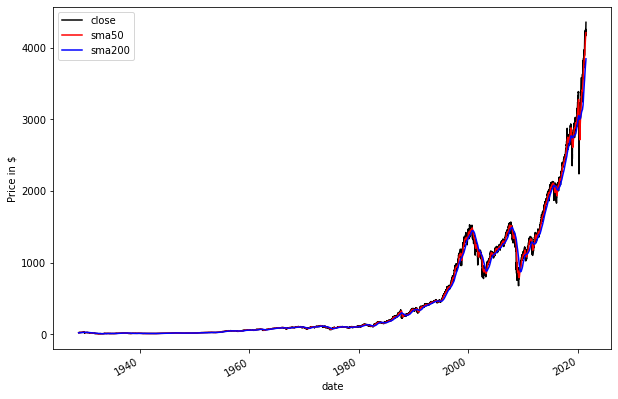

In [9]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma50'].plot(ax=axes, label='sma50', color='r')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [10]:
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [11]:
pf.TradeLog.cash = capital

import time
t0 = time.time()

"""
# This is not the fatest, but allows you the Dataframe directly (769 msec).
for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]; low = ts['low'][i]; close = ts['close'][i]
    sma50 = ts['sma50'][i]; sma200 = ts['sma200'][i]

# This is the slowest (1.481 sec).
for i, (index, row) in enumerate(ts.iterrows()):

    date = index
    high = row['high']; low = row['low']; close = row['close']
    sma50 = row['sma50']; sma200 = row['sma200']

# Using .at[] is faster (517 msec).
for i, index in enumerate(ts.index):

    date = index
    high = ts.at[index, 'high']; low = ts.at[index, 'low']; close = ts.at[index, 'close']
    sma50 = ts.at[index, 'sma50']; sma200 = ts.at[index, 'sma200']

# Converting to dict is supposed to be fastest, but it isn't (1.215 msec).
# The looping itself is fast (129 msec), but the conversion to dict takes too long.
# Also, a new column must be created for the index, which takes time.
ts['date'] = ts.index
ts_dict = ts.to_dict('records')
for i, row in enumerate(ts_dict):

    date = row['date']
    high = row['high']; low = row['low']; close = row['close']
    sma50 = row['sma50']; sma200 = row['sma200']

# Using itertuples is by far fastest for looping (219 msec)
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high; low = row.low; close = row.close
    sma50 = row.sma50; sma200 = row.sma200
"""

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    close = row.close
    sma50 = row.sma50; sma200 = row.sma200
    end_flag = pf.is_last_row(ts, i)
    shares = 0
    
    # Buy
    if tlog.shares == 0:
        if sma50 > sma200 and ts['sma50'][i-1] <= ts['sma200'][i-1]:
            # Enter buy in trade log
            shares = tlog.buy(date, close)  
    # Sell
    else:
        if sma50 < sma200 or end_flag:
            # Enter sell in trade log
            shares = tlog.sell(date, close)

#     if shares > 0:
#         print("{0} BUY  {1} {2} @ {3:.2f}".format(
#               date, shares, symbol, close))
#     elif shares < 0:
#         print("{0} SELL {1} {2} @ {3:.2f}".format(
#               date, -shares, symbol, close))

    # Record daily balance
    dbal.append(date, close)  

t1 = time.time()
total = t1-t0
print(total)
        

0.15997886657714844


Retrieve raw log and trade log DataFrames

In [12]:
rlog = tlog.get_log_raw()
tlog = tlog.get_log()

In [13]:
rlog.tail()

,date,seq_num,price,shares,entry_exit,direction,symbol
91,2018-12-07,91,2633.08,897,exit,LONG,^GSPC
92,2019-04-01,92,2867.19,823,entry,LONG,^GSPC
93,2020-03-30,93,2626.65,823,exit,LONG,^GSPC
94,2020-07-09,94,3152.05,686,entry,LONG,^GSPC
95,2021-07-02,95,4352.34,686,exit,LONG,^GSPC


View trade log

In [14]:
tlog.head(50)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
0,1932-09-19,7.34,1933-03-27,6.09,-1.25,-1702.50,1362,-1702.50,LONG,^GSPC
1,1933-05-18,8.89,1934-05-31,9.61,0.72,671.76,933,-1030.74,LONG,^GSPC
2,1935-05-23,10.07,1937-05-21,16.27,6.20,5518.00,890,4487.26,LONG,^GSPC
3,1938-07-27,12.25,1939-03-31,10.98,-1.27,-1501.14,1182,2986.12,LONG,^GSPC
4,1939-09-18,12.47,1940-03-20,12.14,-0.33,-343.53,1041,2642.59,LONG,^GSPC
5,1940-12-13,10.69,1941-02-21,9.76,-0.93,-1099.26,1182,1543.33,LONG,^GSPC
6,1941-08-18,10.13,1941-11-18,9.26,-0.87,-990.93,1139,552.40,LONG,^GSPC
7,1942-08-14,8.58,1943-12-01,11.13,2.55,3133.95,1229,3686.35,LONG,^GSPC
8,1944-03-13,12.24,1946-08-28,16.73,4.49,5019.82,1118,8706.17,LONG,^GSPC
9,1947-07-25,16.08,1948-01-22,14.42,-1.66,-1930.58,1163,6775.59,LONG,^GSPC


In [15]:
dbal = dbal.get_log(tlog)
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-06-28,2945563.08,2945563.08,2945563.08,686,2204.72,1.00,-
2021-06-29,2946379.38,2946379.38,2946379.38,686,2204.72,1.00,-
2021-06-30,2950289.72,2950289.72,2950289.72,686,2204.72,1.00,-
2021-07-01,2965683.52,2965683.52,2965683.52,686,2204.72,1.00,-
2021-07-02,2987909.85,2987909.85,2987909.85,0,2987909.85,1.00,X


In [16]:
close = dbal['close']
close

date
1928-10-16     10000.00
1928-10-17     10000.00
1928-10-18     10000.00
1928-10-19     10000.00
1928-10-22     10000.00
                ...    
2021-06-28   2945563.08
2021-06-29   2946379.38
2021-06-30   2950289.72
2021-07-01   2965683.52
2021-07-02   2987909.85
Name: close, Length: 23289, dtype: float64

Generate strategy stats - display all available stats

In [17]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   1928-10-16
end                                                     2021-07-02
beginning_balance                                            10000
ending_balance                                          2987909.85
total_net_profit                                        2977909.85
gross_profit                                            3332771.19
gross_loss                                              -354861.34
profit_factor                                                 9.39
return_on_initial_capital                                 29779.10
annual_return_rate                                            6.34
trading_period                           92 years 8 months 16 days
pct_time_in_market                                           66.22
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

Run Benchmark

In [18]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=use_adj)
benchmark.run()

dir_name data


Plot Equity Curves: Strategy vs Benchmark

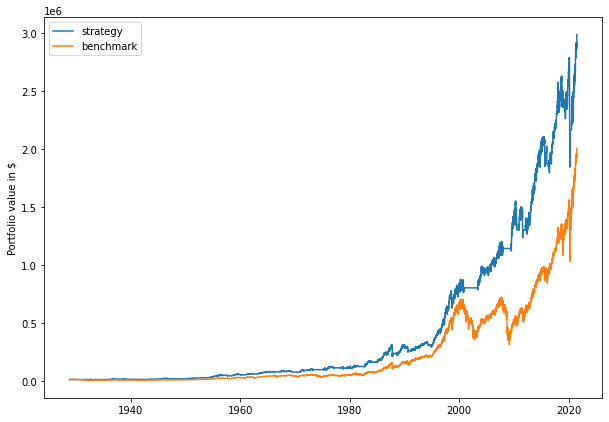

In [19]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

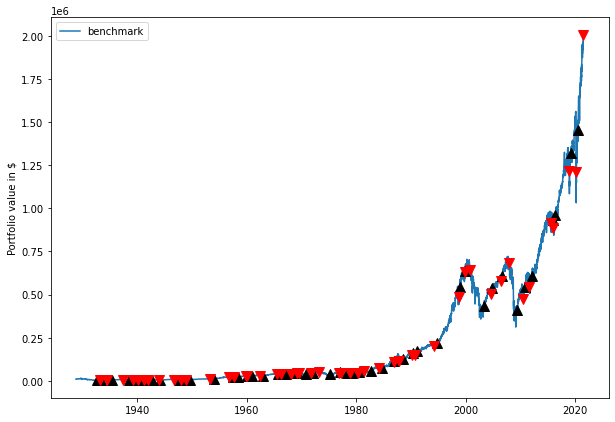

In [20]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Strategy vs Benchmark

In [21]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$2,987,909.85","$2,006,429.91"
total_net_profit,"$2,977,909.85","$1,996,429.91"
gross_profit,"$3,332,771.19","$1,996,429.91"
gross_loss,"-$354,861.34",$0.00


,strategy,benchmark
annual_return_rate,6.34,5.88
max_closed_out_drawdown,-36.86,-86.16
annualized_return_over_max_drawdown,0.17,0.07
best_month,22.49,61.49
worst_month,-30.91,-42.17
sharpe_ratio,0.54,0.40
sortino_ratio,0.54,0.50
monthly_std,3.29,5.34
annual_std,13.00,20.01
avg_month,0.54,0.60


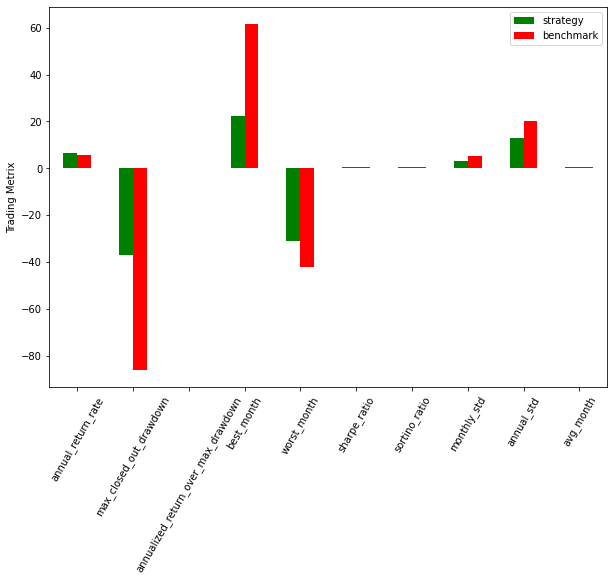

In [22]:
extras = ('avg_month',)

df = pf.plot_bar_graph(stats, benchmark.stats, extras=extras)
df